In [118]:
import numpy as np
import scipy
from scipy.sparse import coo_matrix

def construct_X(M, alphas, Np=None):
    # Total number of pixels in the tomogram
    D = M * M  
    # Number of projection angles
    No = len(alphas)  
    
    if Np is None:
        # Default sensor resolution
        Np = int(np.ceil(np.sqrt(2) * M))  
    # Total number of sensor elements
    N = No * Np  

    h = 1  # Pixel distance
    
    # Define the coordinates of the tomogram's pixel centers
    a0 = -(M-1) / 2
    b0 = -(M-1) / 2
    ja, jb = np.mgrid[0:M, 0:M].reshape(2, -1)
    C0, C1 = [], []

    for i in range(0, M*M):
        C0.append(a0 + ja[i] * h)
        C1.append(b0 + jb[i] * h)
    C = np.array([C0, np.flip(C1,0)])

    X_entries = []
    i_indices = []
    j_indices = []
    
    for io, alpha in enumerate(alphas):
        # Convert angle to radians
        alpha_rad = np.radians(alpha)  

        # Compute the current orientation as a unit vector
        n = np.array([np.cos(alpha_rad), np.sin(alpha_rad)])

        # Compute the projection of each pixel onto the sensor
        # Distance between the first sensor element and the coordinate origin
        s0 = (Np - 1) / 2  
        p = np.dot(n.T, C) + s0
        
        # Compute the weights for each pixel
        # Sensor element indices
        ip = np.floor(p).astype(int)
        ip_add = ip + 1
        rest_intensity = p - ip  
        weights = np.array([1 - rest_intensity, rest_intensity])
        
        # Keep track of the non-zero entries of X
        valid_indices = np.where((ip < Np))[0]
        valid_ip = ip[valid_indices]
        valid_j = ja[valid_indices] + M * jb[valid_indices]
        valid_weights = weights[0,:][valid_indices]
        for w in valid_weights:
            X_entries.append(w)
        i_indices.extend(valid_ip + Np * io)
        j_indices.extend(valid_j)

        valid_indices = np.where((ip_add < Np))[0]
        valid_ip_add = ip_add[valid_indices]
        valid_j = ja[valid_indices] + M * jb[valid_indices]
        valid_weights = weights[1,:][valid_indices]
        for w in valid_weights:
            X_entries.append(w)
        i_indices.extend(valid_ip_add + Np * io)
        j_indices.extend(valid_j)

    X = coo_matrix((X_entries, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)

    return X


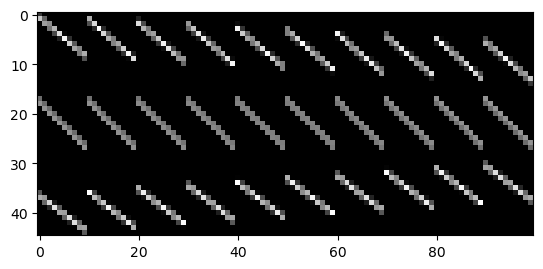

In [119]:
import matplotlib.pyplot as plt

# Example usage
M = 10
alphas = [-33, 1, 42]
X = construct_X(M, alphas, 15)

# Convert sparse matrix to a dense numpy array for visualization
X_dense = X.toarray()

# X_dense = np.flip(X_dense, 0)
# X_dense = np.flip(X_dense, 1)

plt.imshow(X_dense, cmap='gray')
plt.show()


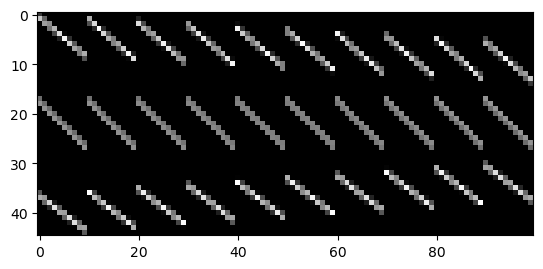

In [103]:
X_ex = np.load('hs_tomography/X_example.npy')

plt.imshow(X_ex, cmap='gray')
plt.show()

In [6]:
import numpy as np
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt

# Load the data
alphas = np.load('hs_tomography/alphas_77.npy')
y = np.load('hs_tomography/y_77.npy')

# Construct X matrix
# ... Code for constructing X matrix ...

# Find the least-squares solution using lsqr solver
X_sparse = scipy.sparse.csc_matrix(X)  # Convert X to sparse matrix
tol = 1e-05  # Tolerance for the solver
beta, _ = linalg.lsqr(X_sparse, y, atol=tol, btol=tol)[:2]

# Reshape beta to a 2D array based on the desired image dimensions
image_width = 10  # Specify the desired image width (number of columns)
image_height = len(beta) // image_width  # Calculate the corresponding image height (number of rows)
image = np.reshape(beta, (image_height, image_width))

# Plot the image
plt.imshow(image, cmap='gray')  # Use a grayscale colormap
plt.title("Reconstructed Tomogram")
plt.colorbar()  # Add a colorbar for reference
plt.show()



ValueError: dimension mismatch

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have reconstructed the tomogram and obtained β as a 1D array or list

# Reshape β to a 2D array based on the desired image dimensions
image_width = 10  # Specify the desired image width (number of columns)
image_height = len(X) // image_width  # Calculate the corresponding image height (number of rows)
image = np.reshape(X, (image_height, image_width))

# Plot the image
plt.imshow(image, cmap='gray')  # Use a grayscale colormap
plt.title("Reconstructed Tomogram")
plt.colorbar()  # Add a colorbar for reference
plt.show()


TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]